# Rossmann Store Sales

Forecast sales using store, promotion, and competitor data

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

# 0.0 Motivation

Store managers attended a monthly status meeting.
CFO requested this solution during a monthly status meeting

# 0.1 The Root Cause of the Problem

CFO wants to renovate stores, so he needs a forecast of the next 6 weeks to renovate stores.

# 0.2 Problem Owner

CFO

# 0.3 Solution Format

- Granularity: Forecast sales per day / store in the next 6 weeks  
- Type of problem: Demand / sales forecast
- Potential methods: Time Series
- Delivery Format: Predictions accessed via cell phone.

# 1.0 Imports

In [170]:
# 1.0 Imports
import warnings
warnings.filterwarnings( 'ignore' )

# 1.1 Helper Function
from IPython.display       import Image
from IPython.core.display  import HTML

# 1.3 Loading Data
import pandas as pd

# 2.1 Rename Columns
import inflection

# 2.5 Fillout NA
import math

# 2.7 Descriptive Statistical
import numpy as np
import seaborn as sns

# 5.2 Bivariate Analysis
from tabulate              import tabulate
from matplotlib.gridspec   import GridSpec

# 5.3 Multivariate Analysis
from scipy.stats           import chi2_contingency

# 6.0 Data Preparation
import pickle

# 6.2 Rescaling
# 6.3 Transformation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 1.1 Helper Function

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2 Data Dictionary

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set  
Store - a unique Id for each store  
Sales - the turnover for any given day (this is what you are predicting)  
Customers - the number of customers on a given day  
Open - an indicator for whether the store was open: 0 = closed, 1 = open  
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None  
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools  
StoreType - differentiates between 4 different store models: a, b, c, d  
Assortment - describes an assortment level: a = basic, b = extra, c = extended  
CompetitionDistance - distance in meters to the nearest competitor store  
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened  
Promo - indicates whether a store is running a promo on that day  
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating  
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2  
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store  

## 1.3 Loading Data

In [4]:
#read the entire dataset in one go to memory
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 2.0 Data Description

In [5]:
df2 = df_raw.copy()

## 2.1 Rename Columns

In [6]:
cols_old = list( df2.columns )

snakecase = lambda x: inflection.underscore( x ) 

cols_new = list( map( snakecase, cols_old ) )

#rename columns
df2.columns = cols_new

## 2.2 Data Dimensions

In [7]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 2.3 Checking Data Types

In [8]:
# convert object to Datetime
df2[ 'date' ] = pd.to_datetime( df2[ 'date' ] )

In [9]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA

In [10]:
#number of missing values per column
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
#colocar as 3 formas de resolver NA

In [12]:
#percentage of missing values
( df2.isna().sum() / df2.shape[0] ).sort_values(ascending = False )

promo_interval                  0.499436
promo2_since_week               0.499436
promo2_since_year               0.499436
competition_open_since_year     0.317878
competition_open_since_month    0.317878
competition_distance            0.002597
open                            0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
school_holiday                  0.000000
promo                           0.000000
state_holiday                   0.000000
store_type                      0.000000
assortment                      0.000000
promo2                          0.000000
store                           0.000000
dtype: float64

## 2.5 Fillout NA

In [13]:
#promo_interval    
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['promo_interval'].fillna(0, inplace = True)
df2['month_map'] = df2['date'].dt.month.map( month_map )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

#promo2_since_week   
df2[ 'promo2_since_week' ] = df2.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ],  axis = 1 )

#promo2_since_year     
df2[ 'promo2_since_year' ] = df2.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ],  axis = 1 )

#competition_open_since_year 
df2[ 'competition_open_since_year' ] = df2.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ],  axis = 1 )

#competition_open_since_month: Store has no nearest competitor or Store has the next competitor but does not know when it opened
df2[ 'competition_open_since_month' ] = df2.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ],  axis = 1 )

#competition_distance: as it is empty, it must be assumed that there is no competitor nearby or he is too far away
df2[ 'competition_distance' ] = df2[ 'competition_distance' ].apply( lambda x:  200000  if math.isnan( x ) else x )


In [14]:
df2.isnull().values.any()

False

In [15]:
df2.isnull().sum().sum()

0

## 2.6 Change Data Types

In [16]:
df2[ 'competition_open_since_month' ] = df2[ 'competition_open_since_month' ].astype( 'int32' )
df2[ 'competition_open_since_year' ] = df2[ 'competition_open_since_year' ].astype( 'int32' )
df2[ 'promo2_since_week' ] = df2[ 'promo2_since_week' ].astype( 'int32' )
df2[ 'promo2_since_year' ] = df2[ 'promo2_since_year' ].astype( 'int32' )

# convert object to Datetime
df2[ 'date' ] = pd.to_datetime( df2[ 'date' ] )

# in order to optimize memory, the allocation space must be reduced
df2 = df2.astype( { col: 'int32' for col in df2.select_dtypes( 'int64' ).columns } )
df2 = df2.astype( { col: 'float32' for col in df2.select_dtypes( 'float64' ).columns } )

In [17]:
df2.dtypes

store                                    int32
day_of_week                              int32
date                            datetime64[ns]
sales                                    int32
customers                                int32
open                                     int32
promo                                    int32
state_holiday                           object
school_holiday                           int32
store_type                              object
assortment                              object
competition_distance                   float32
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int32
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int32
dtype: object

## 2.7 Descriptive Statistical

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int32         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int32         
 4   customers                     1017209 non-null  int32         
 5   open                          1017209 non-null  int32         
 6   promo                         1017209 non-null  int32         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int32         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [19]:
num_attributes = df2.select_dtypes(include = ['int32', 'float32'])
cat_attributes = df2.select_dtypes(exclude = ['int32', 'float32', 'datetime64[ns]'])

### 2.7.1 Numerical Attributes

In [20]:
# Central tendency - median, mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, curtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

d7 = pd.DataFrame(num_attributes.quantile(.25)).T
d8 = pd.DataFrame(num_attributes.quantile(.50)).T
d9 = pd.DataFrame(num_attributes.quantile(.75)).T


# concatenate
m = pd.concat( [d2, d7, d8, d9, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['Atributes','Min','25%','50%','75%', 'Max','Range','Mean','Median','Std', 'Skew', 'Kurtosis']
m

,Atributes,Min,25%,50%,75%,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1.0,280.0,558.0,838.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,2.0,4.0,6.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,405.0,609.0,837.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,1.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,0.0,0.0,1.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,0.0,0.0,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,710.0,2330.0,6910.0,200000.0,199980.0,5935.442871,2330.0,12547.646484,10.242344,147.789719
8,competition_open_since_month,1.0,4.0,7.0,10.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#sales = media e mediana proximas (skew proxima de 0 logo eh proxima de normal, kurtosis = 1 ) 

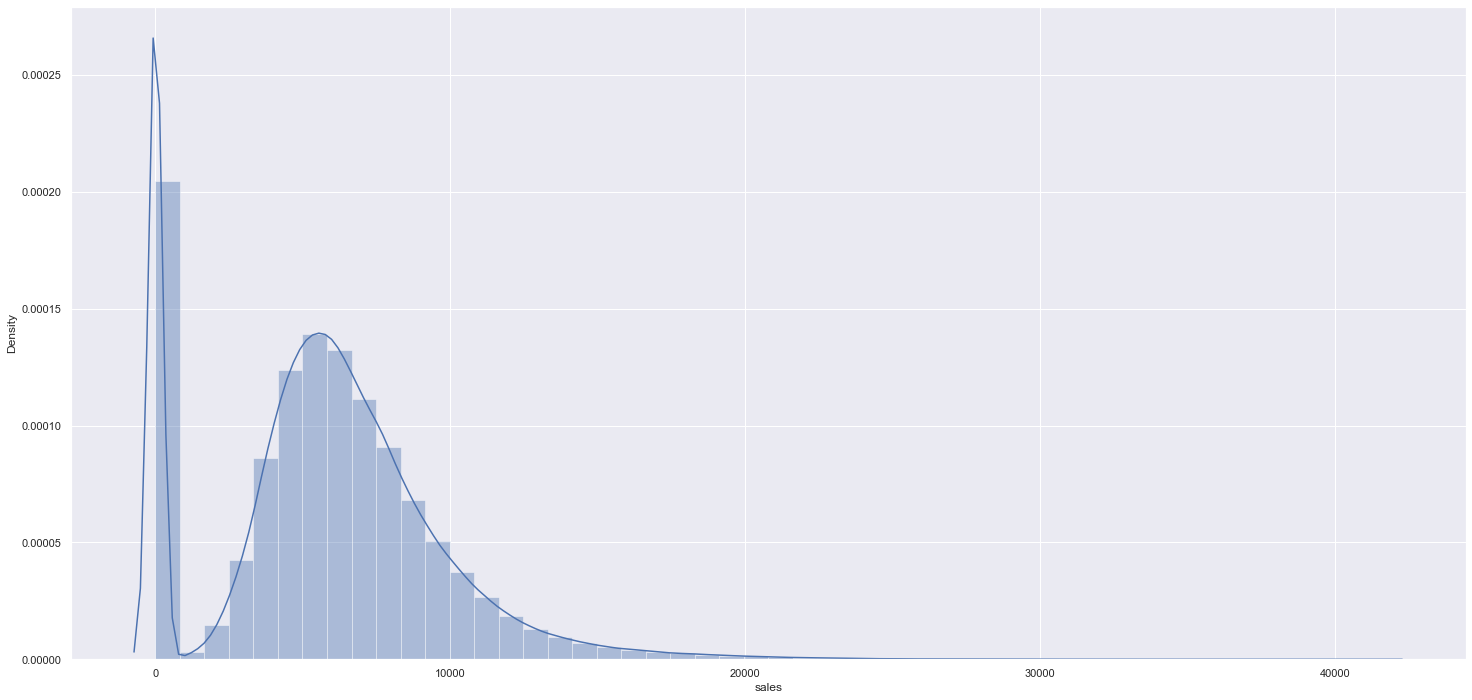

In [22]:
sns.distplot(df2['sales']);

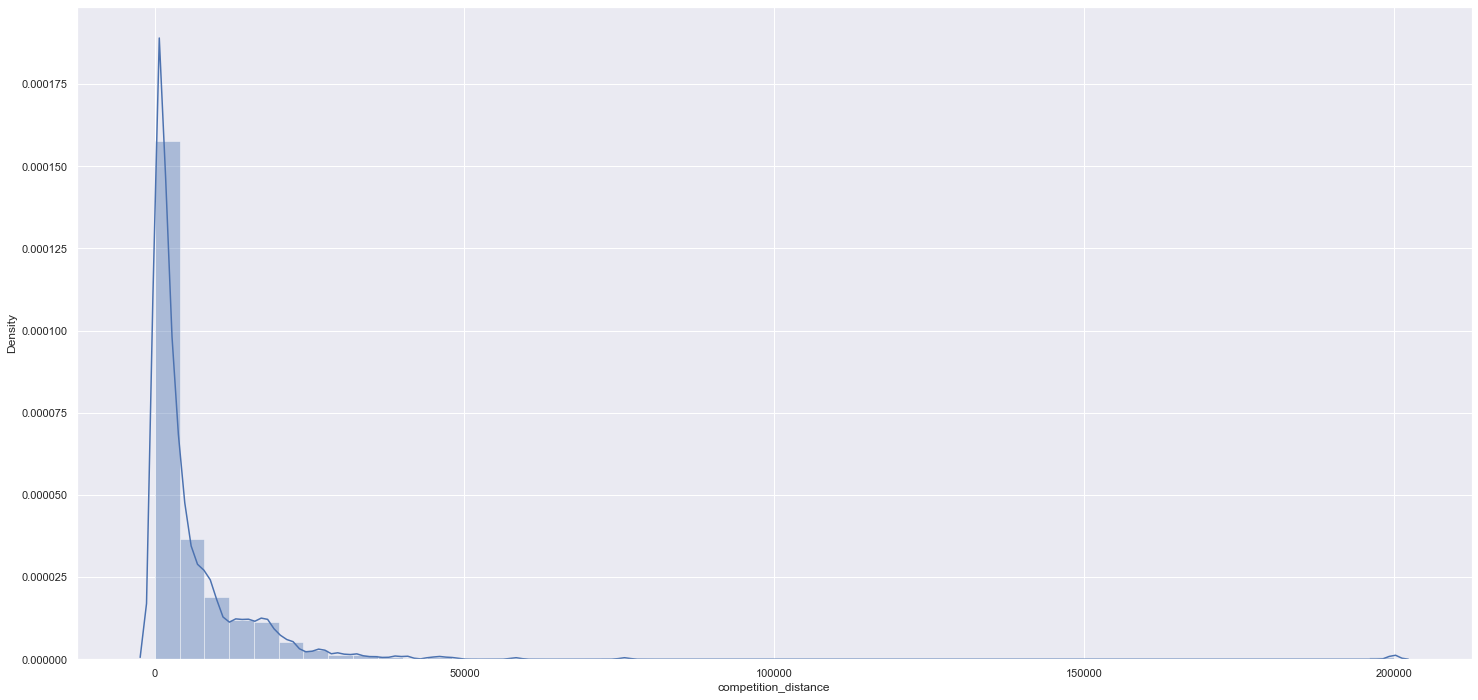

In [23]:
sns.distplot(df2['competition_distance']);

In [24]:
#using Pandas Describe
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442871,12547.653320,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


### 2.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [26]:
cat_attributes.nunique().sort_values(ascending = False)

month_map         12
promo_interval     4
store_type         4
state_holiday      4
assortment         3
dtype: int64

In [27]:
cat_attributes.describe(include=[object])

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,4,12
top,0,a,a,0,Mar
freq,986159,551627,537445,508031,103695


<AxesSubplot:xlabel='assortment', ylabel='sales'>

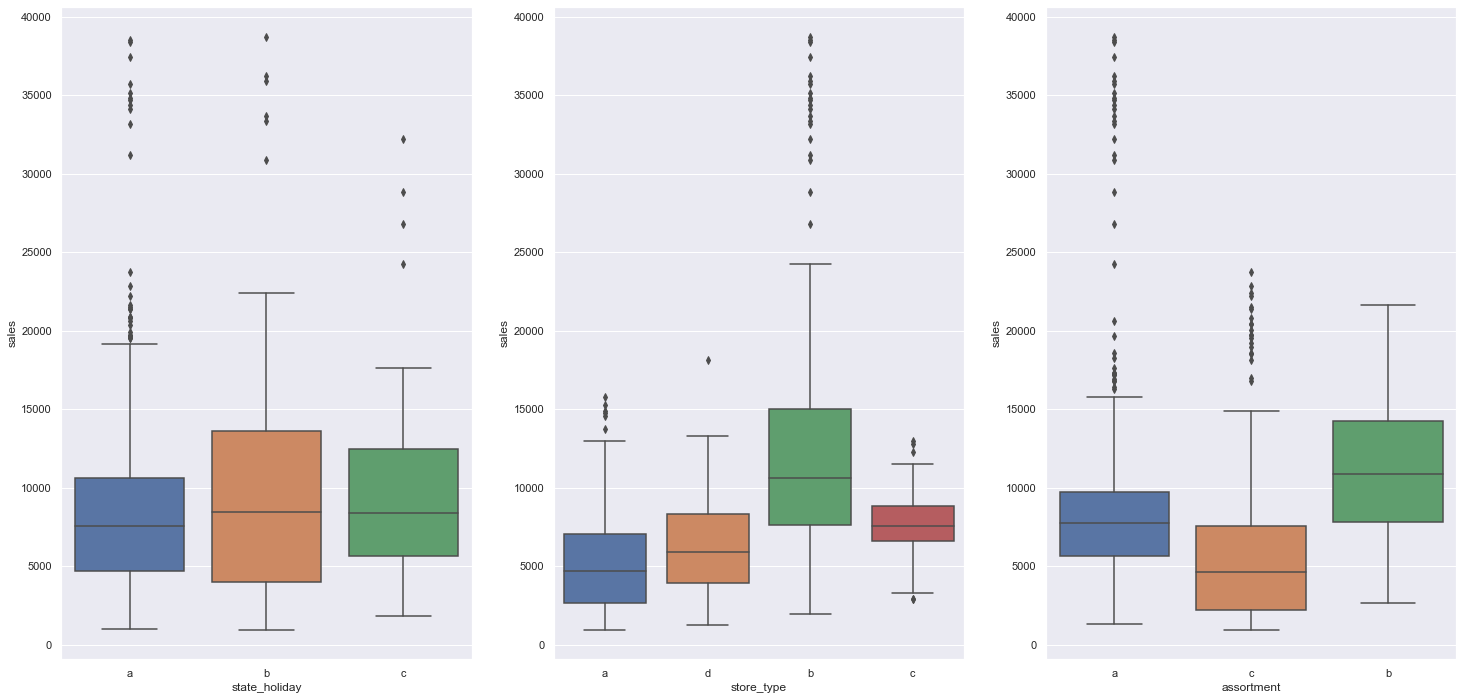

In [28]:
aux = df2[(df2['state_holiday'] != '0') & (df2['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

### 2.8 Save Dataset Clean - Checkpoint

In [29]:
df2.to_csv('data/02_Rossmann_Clean.csv', index = False)

# 3.0. Feature Engineering

In [30]:
df3 = df2.copy()

## 3.1. Hypothesis Mind Map

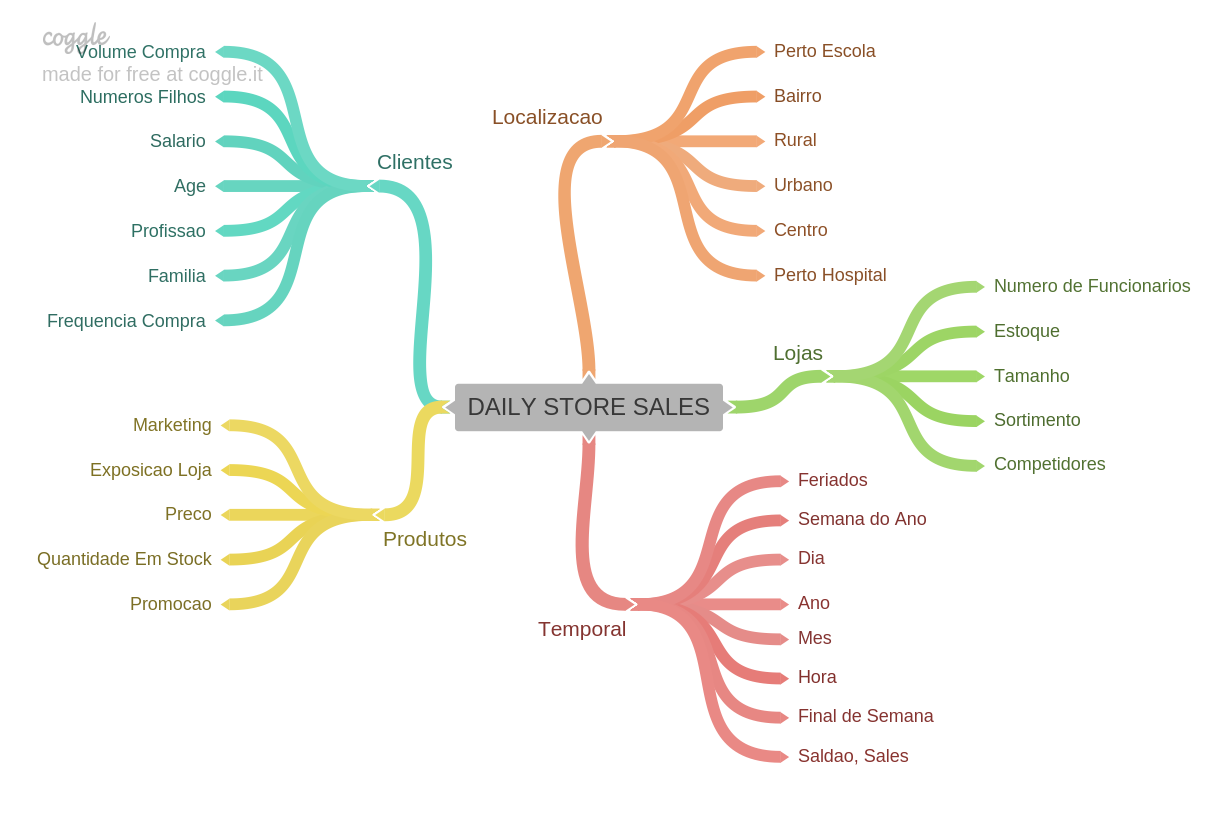

In [31]:
Image( 'img/MindMapHypothesis.png' )

## 3.2. Hypothesis List


**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 3.3. Feature Engineering

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [37]:
#year
df3[ 'year' ] = df3[ 'date' ].dt.year

#month
df3[ 'month' ] = df3[ 'date' ].dt.month

#day
df3[ 'day' ] = df3[ 'date' ].dt.day

#weak of year
df3[ 'week_of_year' ] = df3[ 'date' ].dt.weekofyear

#year week
df3[ 'year_week' ] = df3[ 'date' ].dt.strftime( '%Y-%W')

#competition since
df3[ 'competition_since' ] = df3.apply(lambda x: datetime.datetime(year = x[ 'competition_open_since_year' ] , month = x[ 'competition_open_since_month' ], day = 1), axis = 1)
df3['competition_time_month'] = ( ( df3[ 'date' ] - df3[ 'competition_since' ] ) / 30).apply( lambda x: x.days ).astype( 'int32' )

#promo since
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo_since'] = df3['promo_since'].apply( lambda x:  datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ) )
df3['promo_time_week'] = ( ( df3[ 'date' ] - df3[ 'promo_since' ] ) / 7).apply( lambda x: x.days ).astype( 'int32' )

#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas'  if x == 'c' else 'regular_day')

# in order to optimize memory, the allocation space must be reduced
df3 = df3.astype( { col: 'int32' for col in df3.select_dtypes( 'int64' ).columns } )
df3 = df3.astype( { col: 'float32' for col in df3.select_dtypes( 'float64' ).columns } )

In [38]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.4. Save Dataset - Checkpoint

In [40]:
df3.to_csv('data/03_Rossmann.csv', index = False)

# 4.0. Filtering Variable

In [41]:
df4 = df3.copy()

## 4.1 Line Filtering

In [42]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

## 4.2 Column Selection

In [43]:
df4 = df4.drop(['customers', 'open', 'promo_interval', 'month_map'], axis = 1)

## 4.3 Save Dataset - Checkpoint

In [44]:
df4.to_csv('data/04_Rossmann.csv', index = False)

# 5.0 Exploratory Data Analysis

Exploratory Data Analysis have 3 objectives:  
1-Gain business experience  
2-Validate business hypotheses (Insights)  
3-Realize variables that are important for the model  

In [45]:
df5 = df4.copy()

## 5.1 Univariate Analysis

### 5.1.1 Response Variable

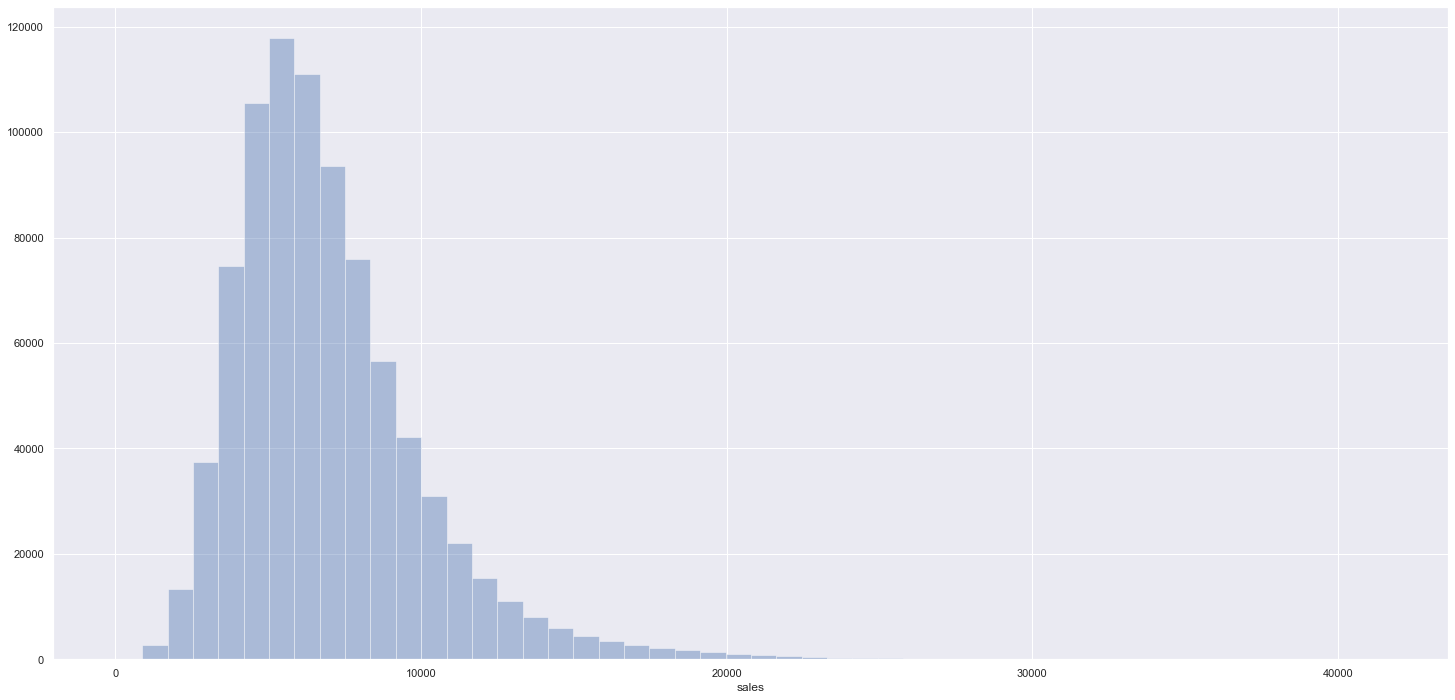

In [46]:
sns.distplot(df5['sales'], kde = False);

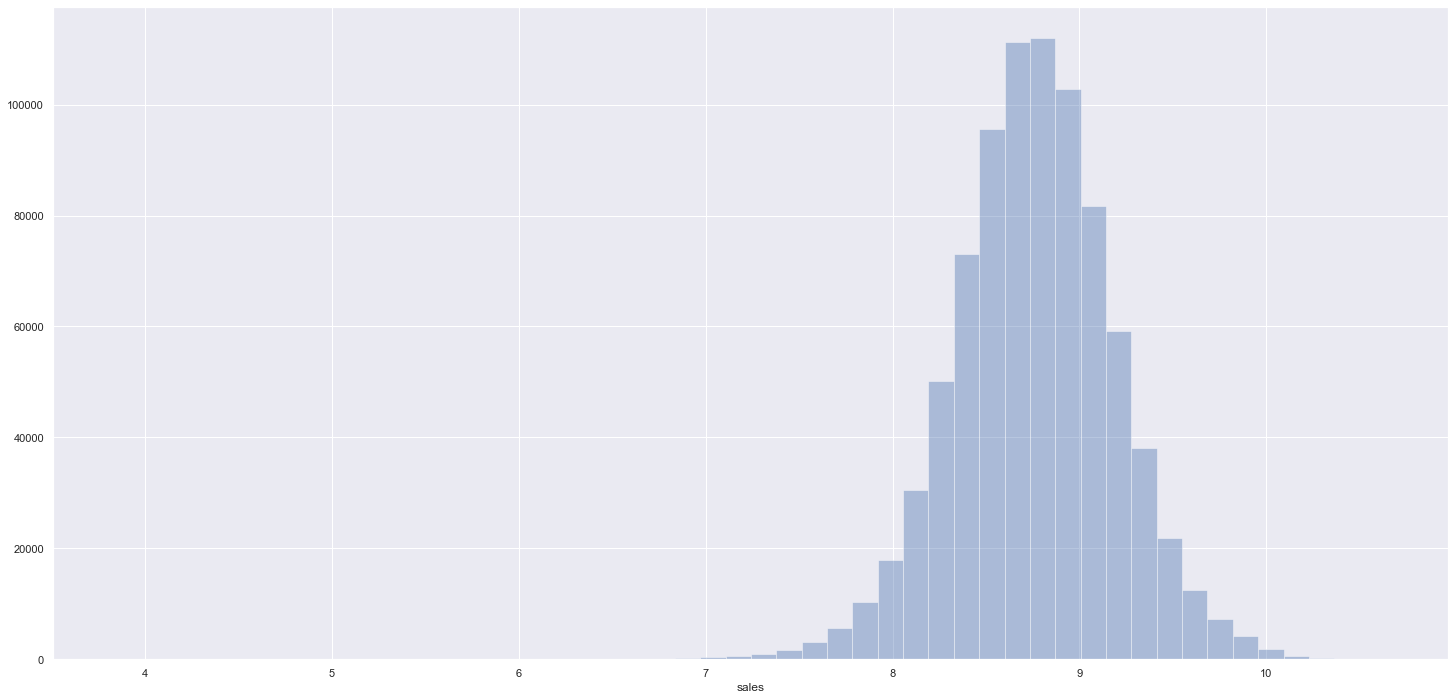

In [47]:
sns.distplot(np.log1p(df5['sales']), kde = False);

### 5.1.2 Numerical Variable

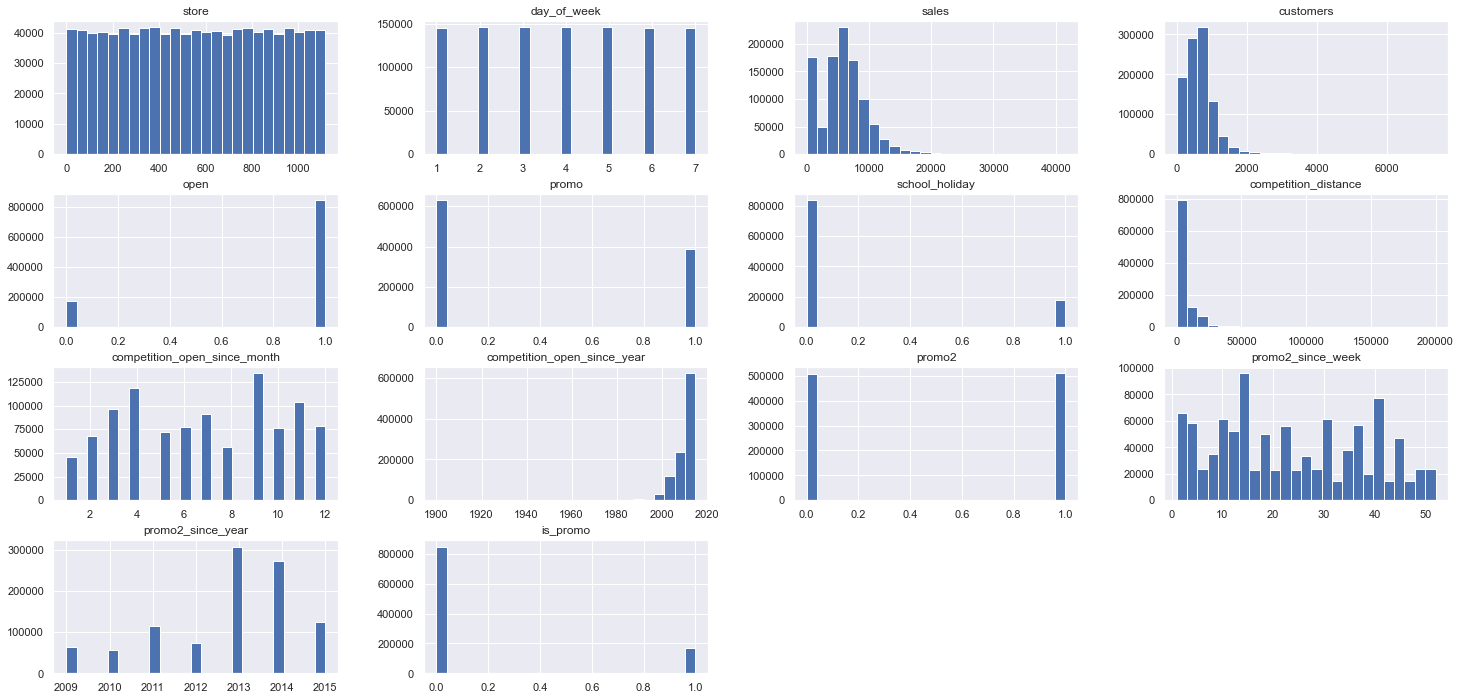

In [50]:
num_attributes.hist(bins = 25);

day_of_week nao tem comportamento relevante para o aprendizado do modelo  
promo2_since_week tem pico de vendas em 2013

### 5.1.3 Categorical Variable

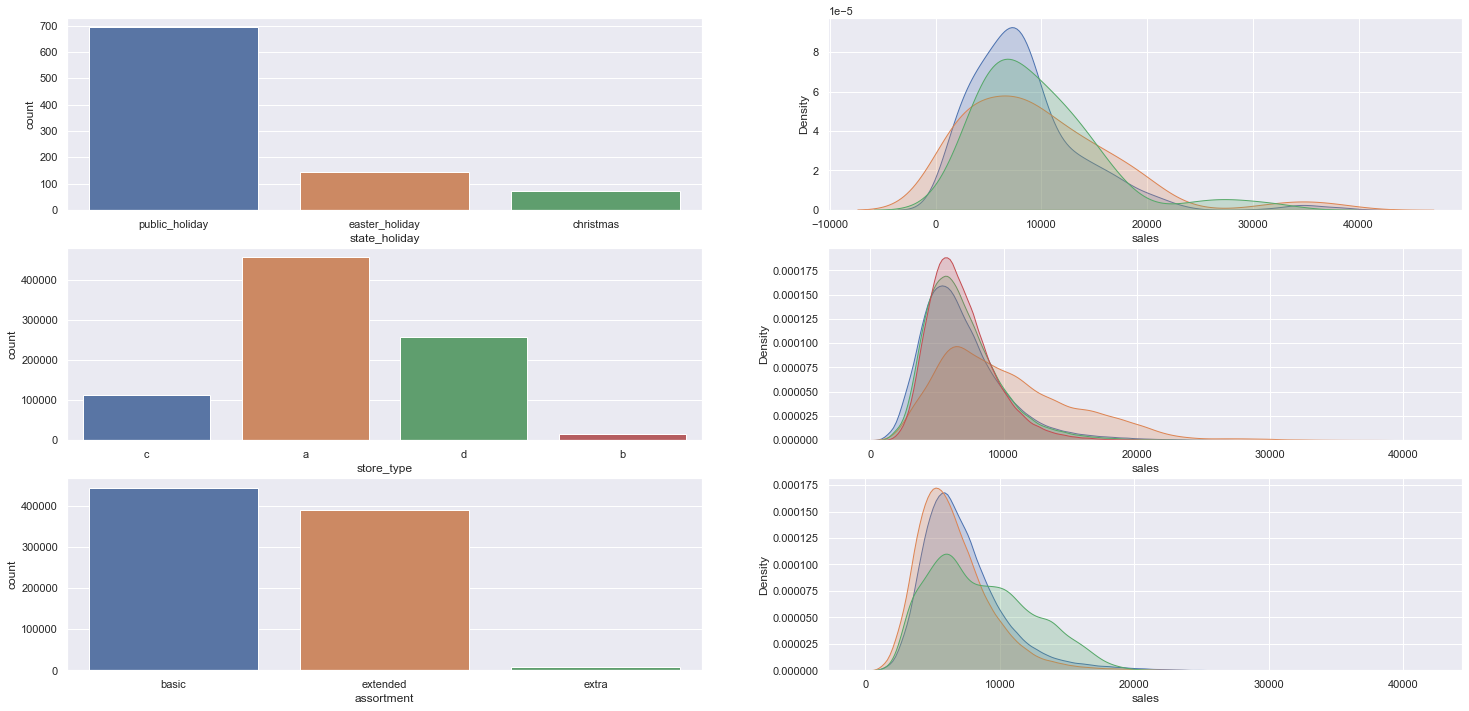

In [51]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df5[df5['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df5['store_type'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df5[df5['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df5[df5['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df5[df5['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df5[df5['store_type'] == 'd']['sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df5['assortment'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );

## 5.2 Bivariate Analysis

In [53]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### **1.** Stores with a larger assortment should sell more.  
**TRUE**

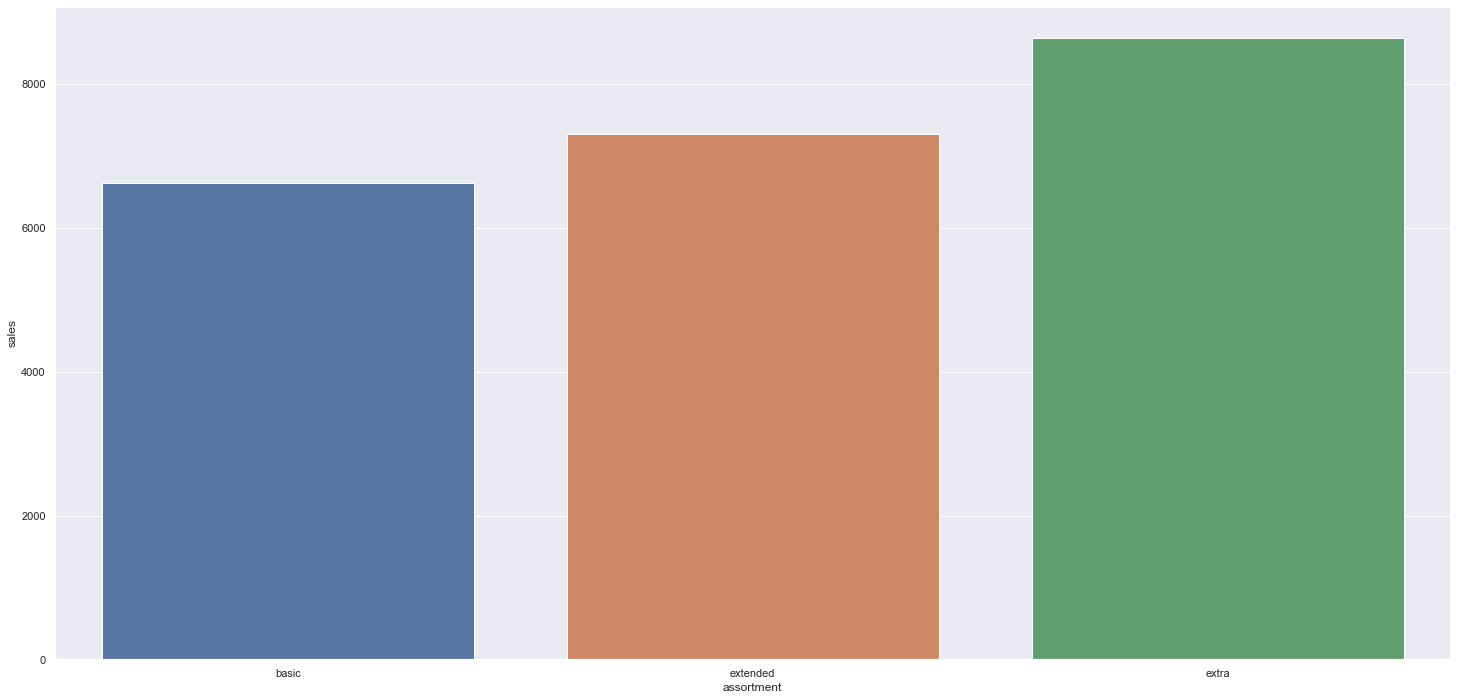

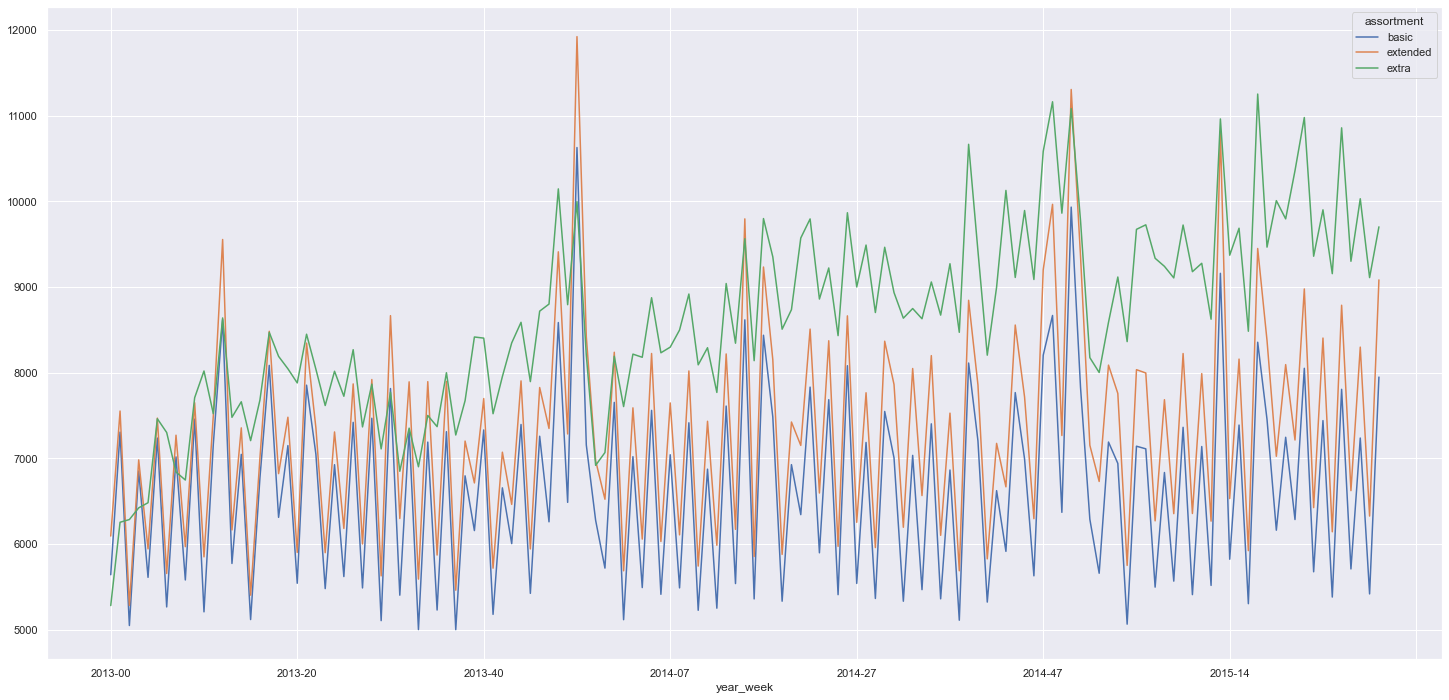

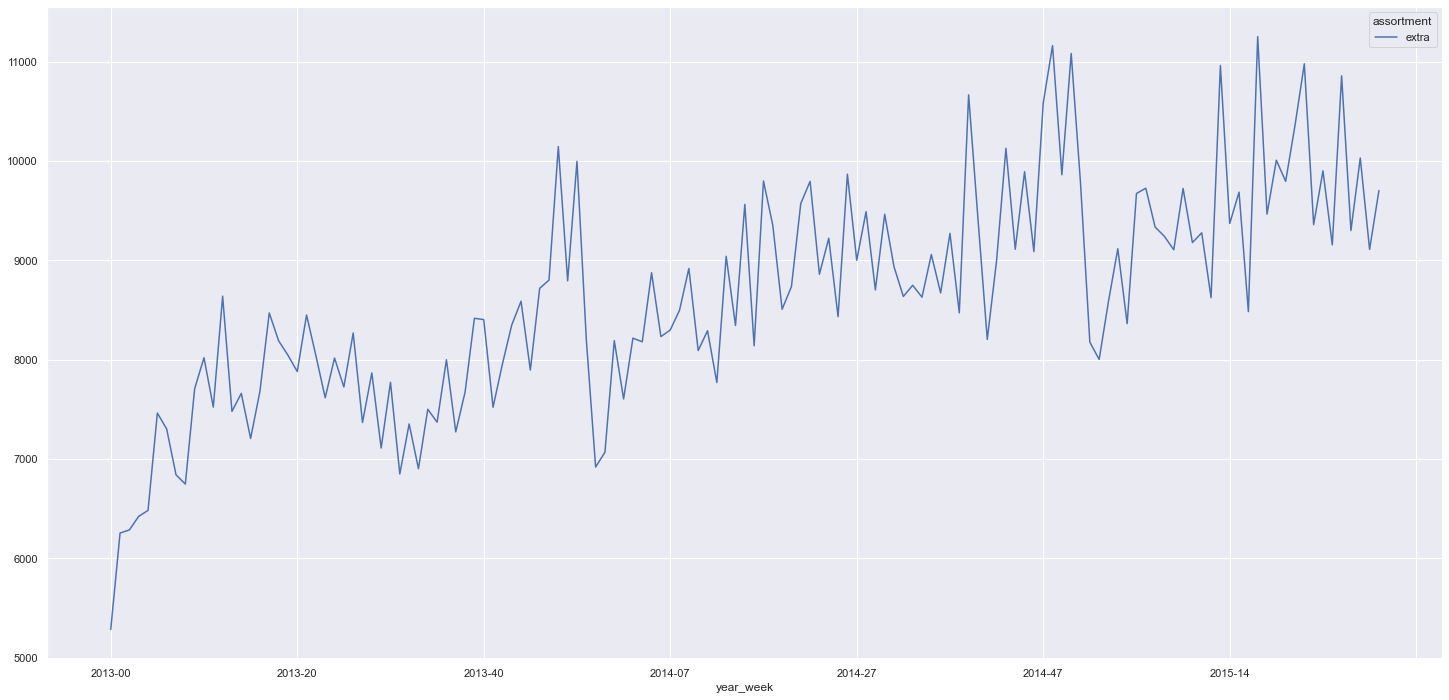

In [57]:
aux1 = df5[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1 );

aux2 = df5[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment',values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **2.** Stores with closer competitors should sell less.  
**FALSE.** Stores with closer competitors should sell more.

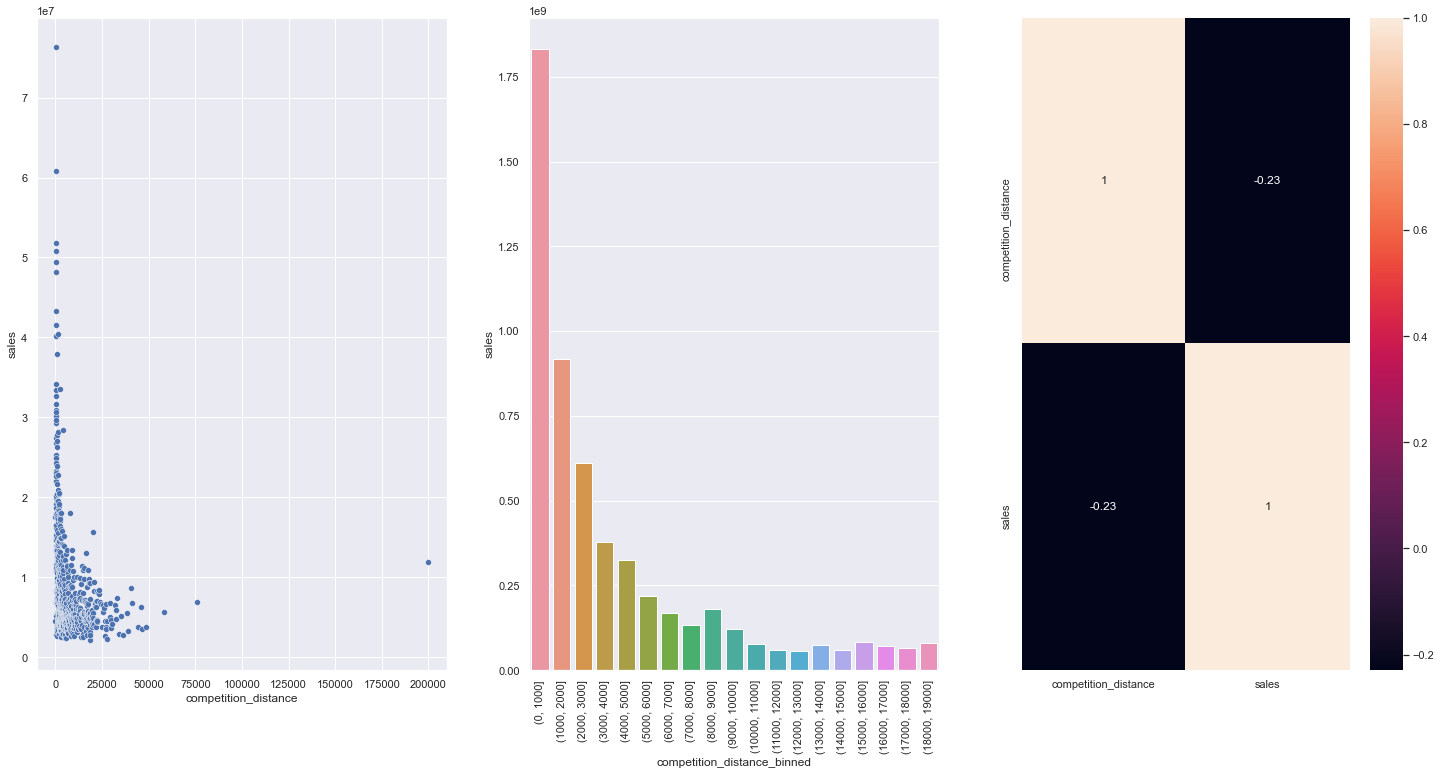

In [58]:
aux1 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins);
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot=True );


### **3.** Stores with longer competitors should sell more.  
**FALSE** The more recent the competition the bigger the sale

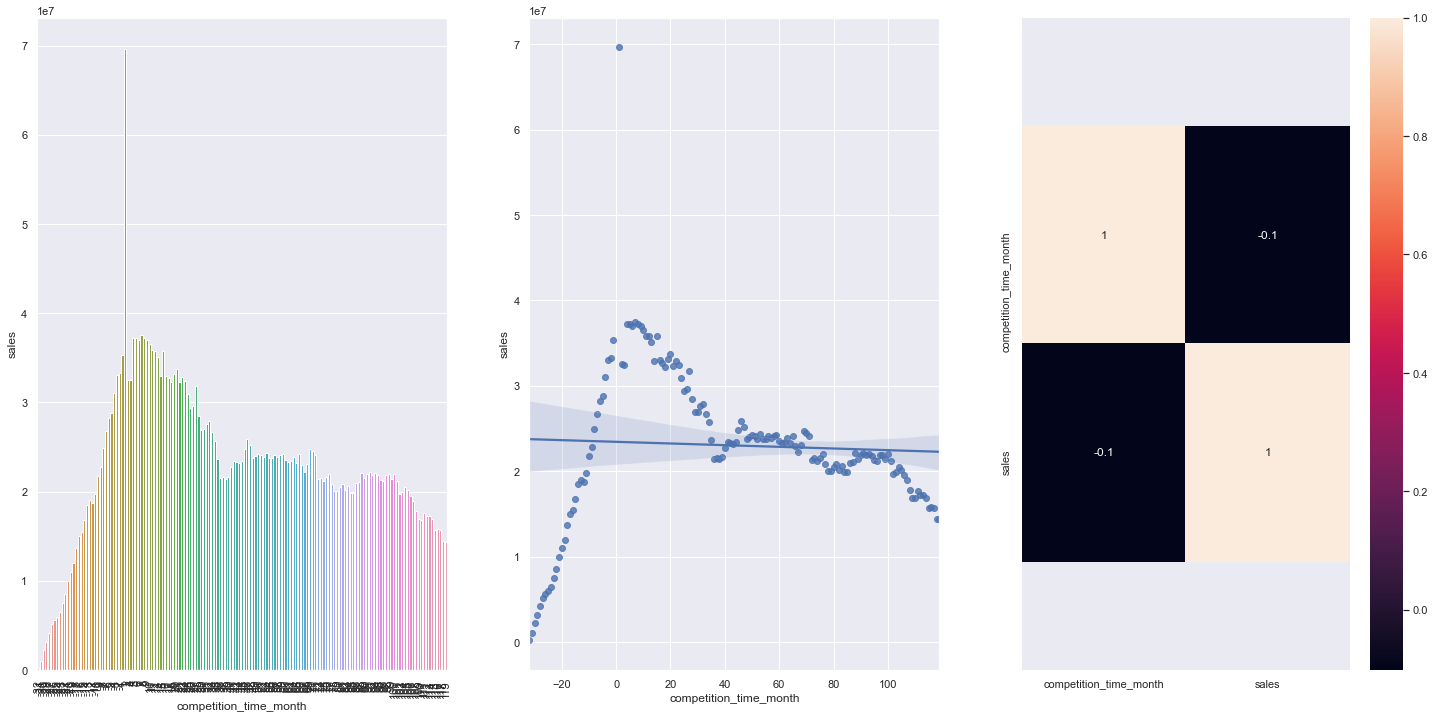

In [60]:
aux1 = df5[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
sns.barplot( x = 'competition_open_since_month', y = 'sales', data = aux1);


plt.subplot( 1, 3, 1 )
aux1 = df5[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### **4.** Stores with active promotions for longer should sell more.  
**FALSE** After a certain period sales fall  

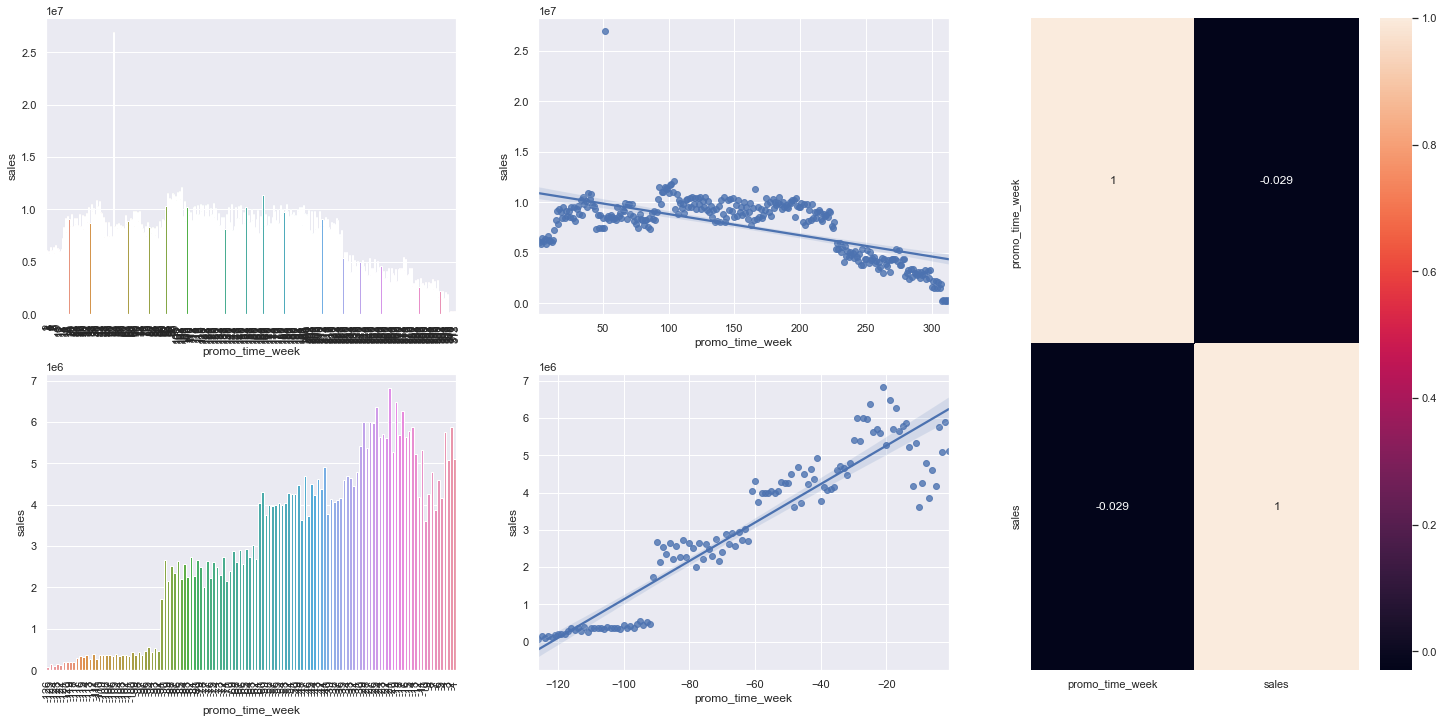

In [62]:
aux1 = df5[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);


grid = GridSpec(2, 3)


plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] #extended time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks( rotation = 90);

plt.subplot( grid[0, 1] )
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] #regular time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks( rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);


**Observations:**  
    -Extended promotion has a period that it works, after that period it has a drop in sales.  
    -When the regular promotion starts, there is an increase in sales (marketing)  

### <s>**5.** Stores with more promotion days should sell more.</s>


### **6.** Stores with more consecutive promotions should sell more.  
**FALSE** Stores with more consecutive promotions should sell less

In [66]:
df5[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


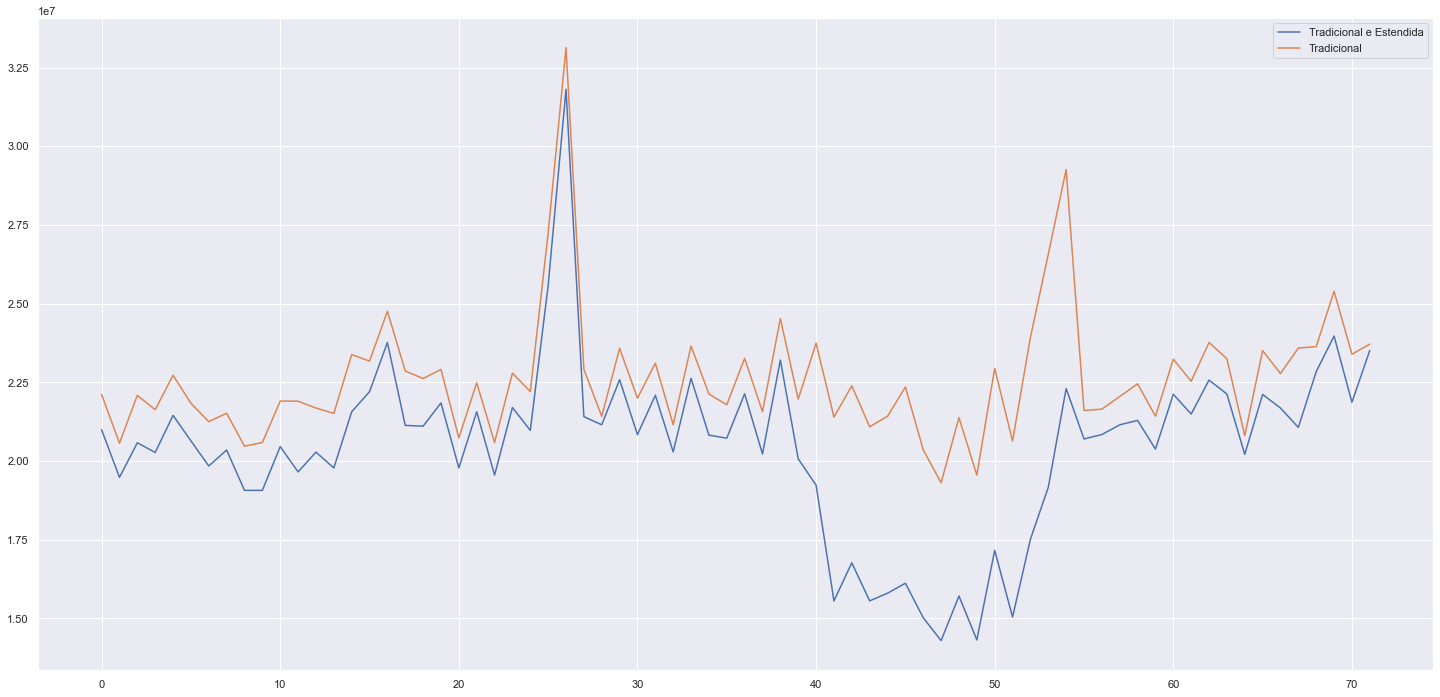

In [67]:
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index() 
ax = aux1.plot();

aux2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index() 
aux2.plot(ax = ax)
ax.legend( labels = ['Tradicional e Estendida', 'Tradicional']);

### **7.** Stores open during the Christmas holiday should sell more.  
**FALSE** Stores open during the Christmas holiday should sell less

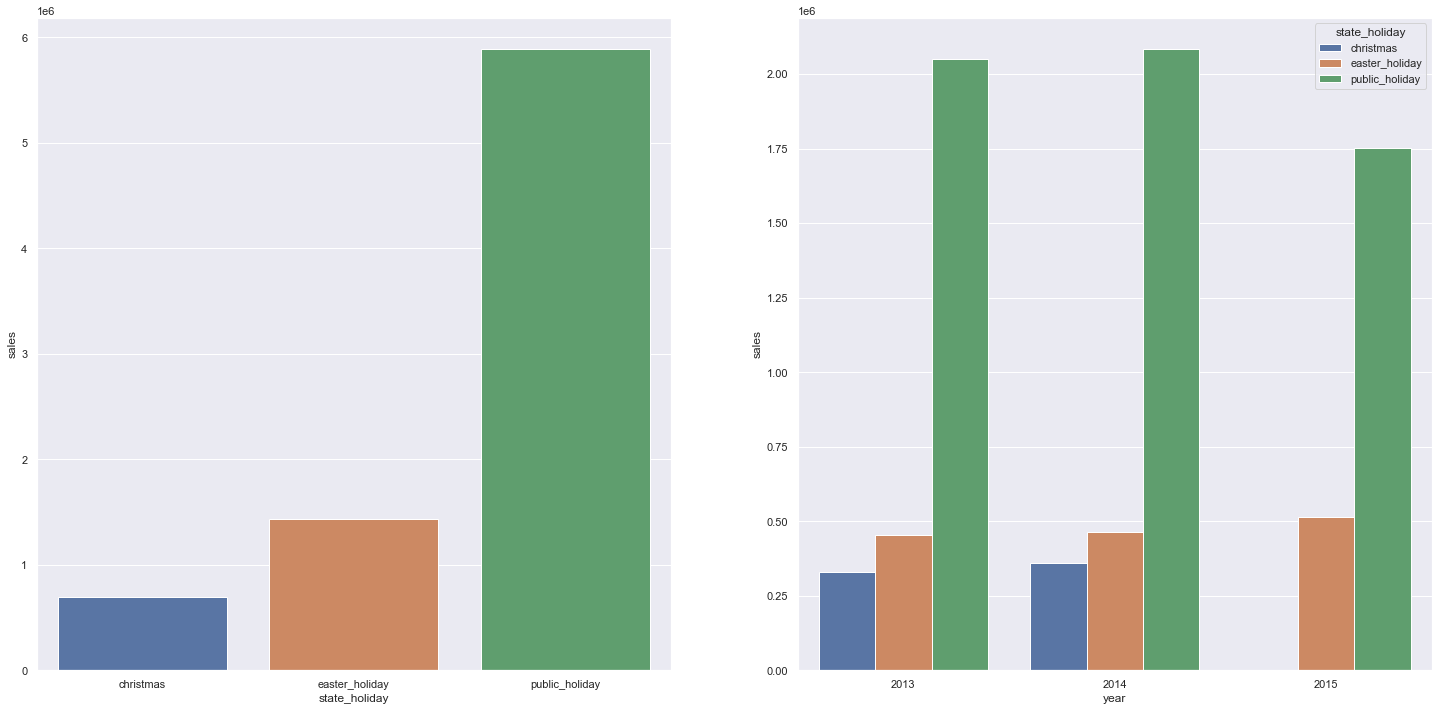

In [69]:
plt.subplot( 1, 2, 1 )
aux = df5[df5['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);


plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2 );

### **8.** Stores should sell more over the years.  
**FALSE** Stores should sell less over the years.

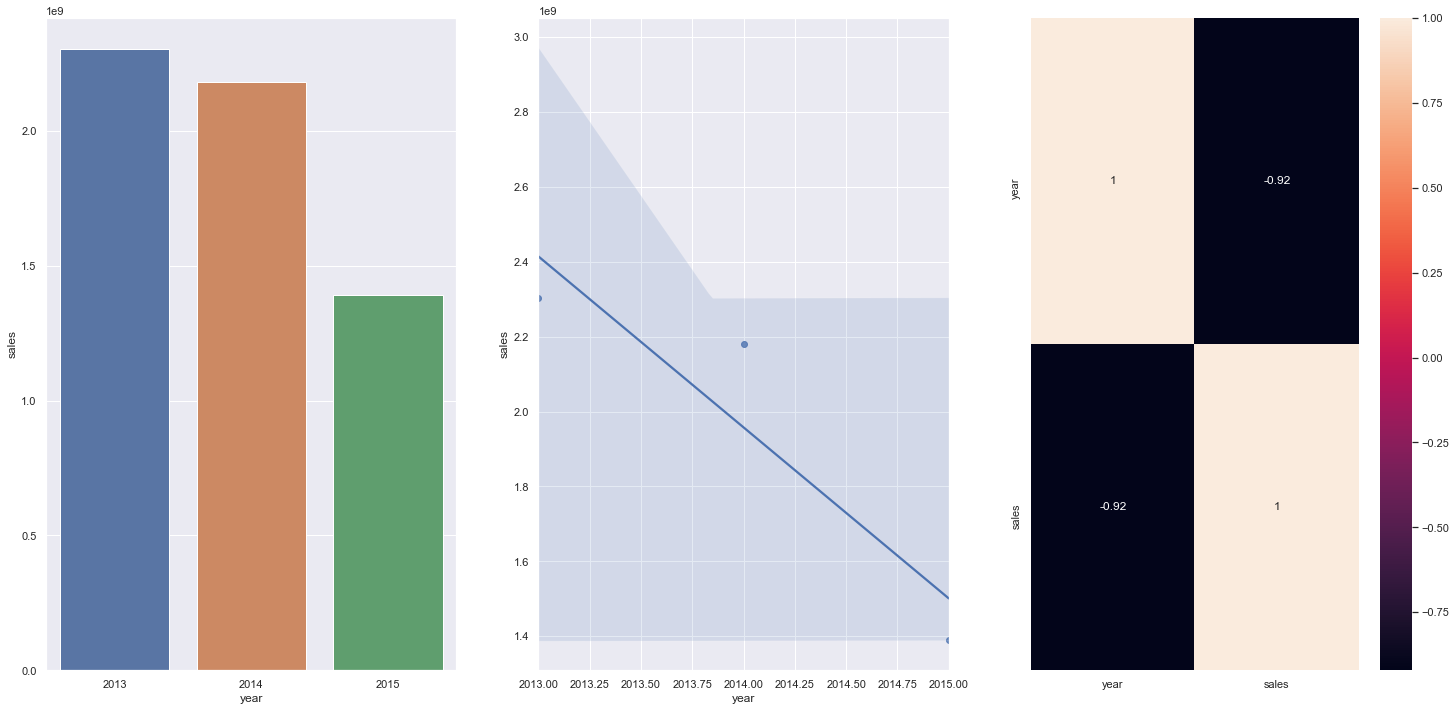

In [72]:
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **9.** Stores should sell more in the second half of the year.  
**FALSE** Stores should sell less in the second half of the year.

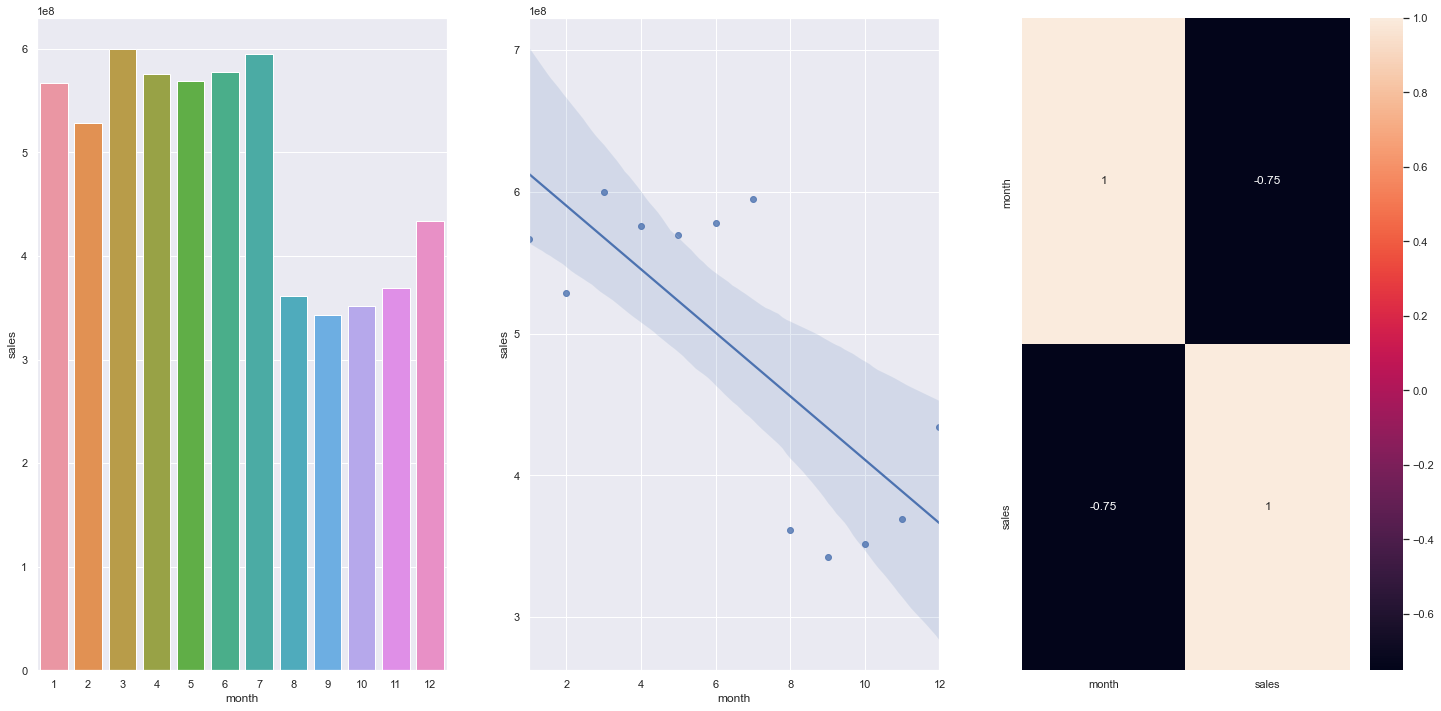

In [74]:
aux1 = df5[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **10.** Stores should sell more after the 10th of each month.  
**TRUE**

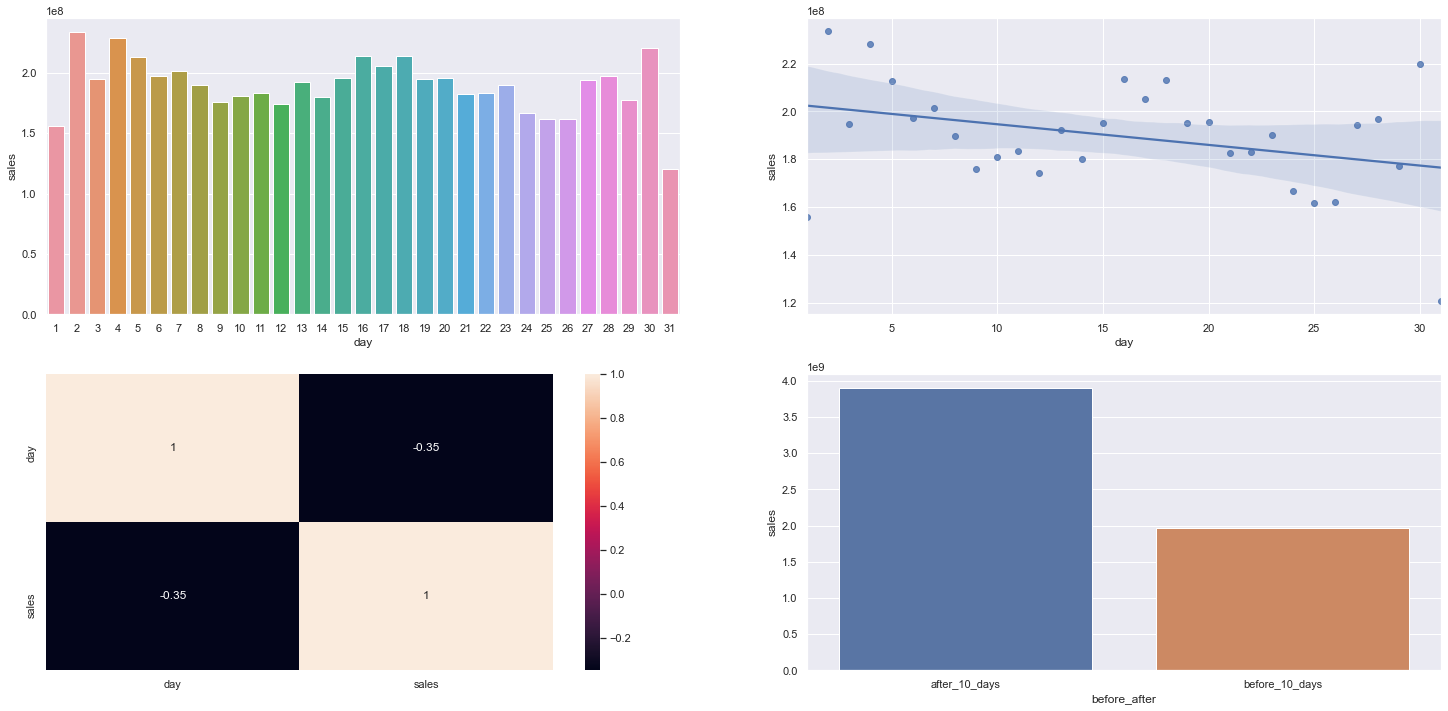

In [76]:
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **11.** Stores should sell less on weekends.  
**TRUE**

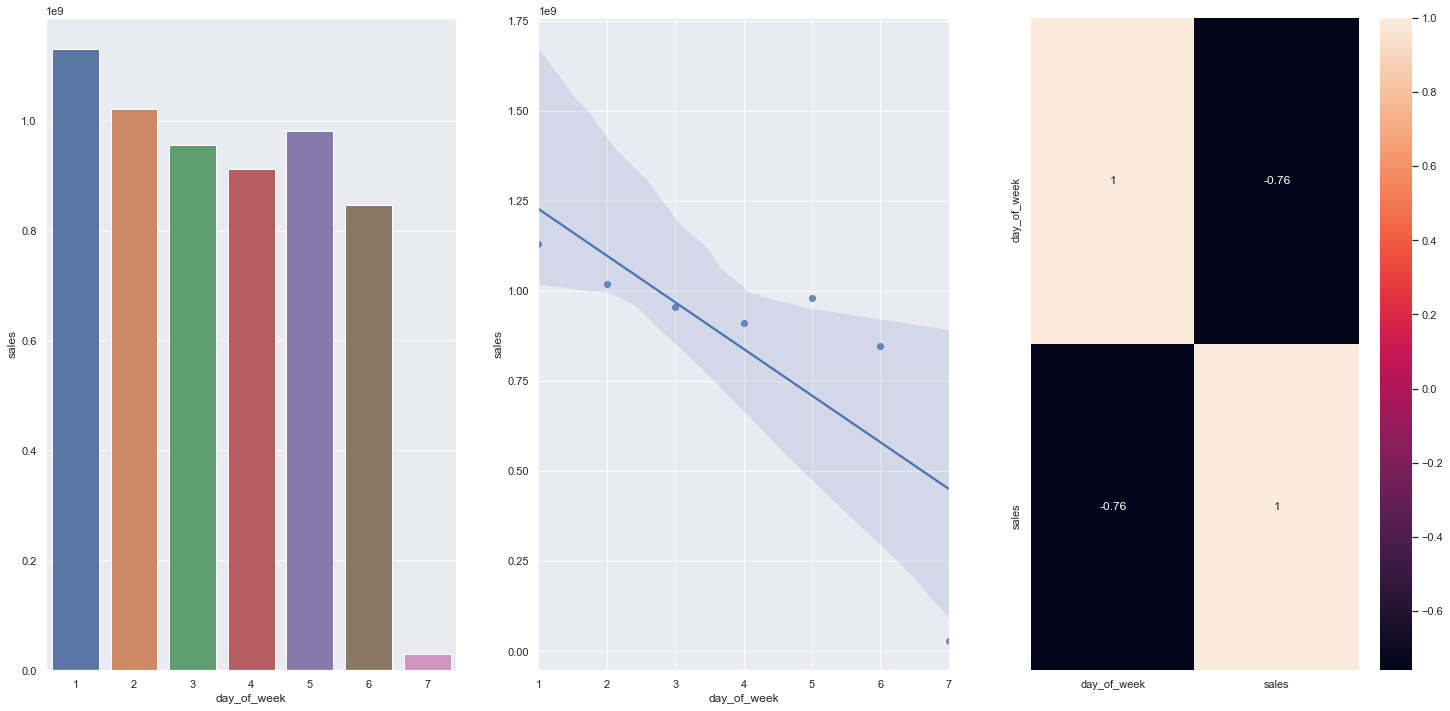

In [78]:
aux1 = df5[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **12.** Stores should sell less during school holidays.
**TRUE**

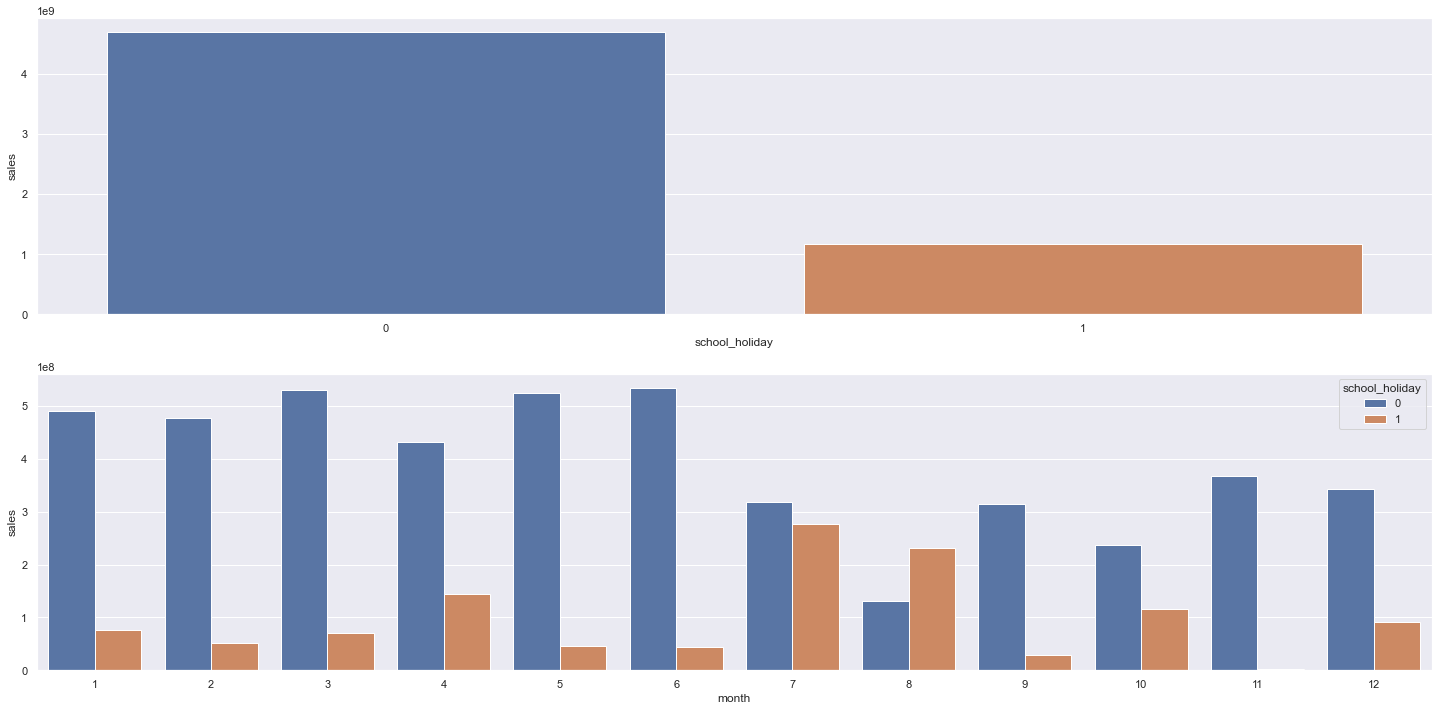

In [80]:
aux1 = df5[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df5[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 5.2.1 Summary of Hypothesis

In [83]:
tab =[['Hypothesis', 'Conclusion', 'Relevancy'],
      ['H1', 'TRUE', 'LOW'],  
      ['H2', 'FALSE', 'MEDIUM'],  
      ['H3', 'FALSE', 'MEDIUM'],
      ['H4', 'FALSE', 'LOW'],
      ['H5', '-', '-'],
      ['H6', 'FALSE', 'LOW'],
      ['H7', 'FALSE', 'MEDIUM'],
      ['H8', 'FALSE', 'HIGH'],
      ['H9', 'FALSE', 'HIGH'],
      ['H10', 'TRUE', 'HIGH'],
      ['H11', 'TRUE', 'HIGH'],
      ['H12', 'TRUE', 'LOW'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevancy
------------  ------------  -----------
H1            TRUE          LOW
H2            FALSE         MEDIUM
H3            FALSE         MEDIUM
H4            FALSE         LOW
H5            -             -
H6            FALSE         LOW
H7            FALSE         MEDIUM
H8            FALSE         HIGH
H9            FALSE         HIGH
H10           TRUE          HIGH
H11           TRUE          HIGH
H12           TRUE          LOW


## 5.3 Multivariate Analysis

### 5.3.1. Numerical Attributes

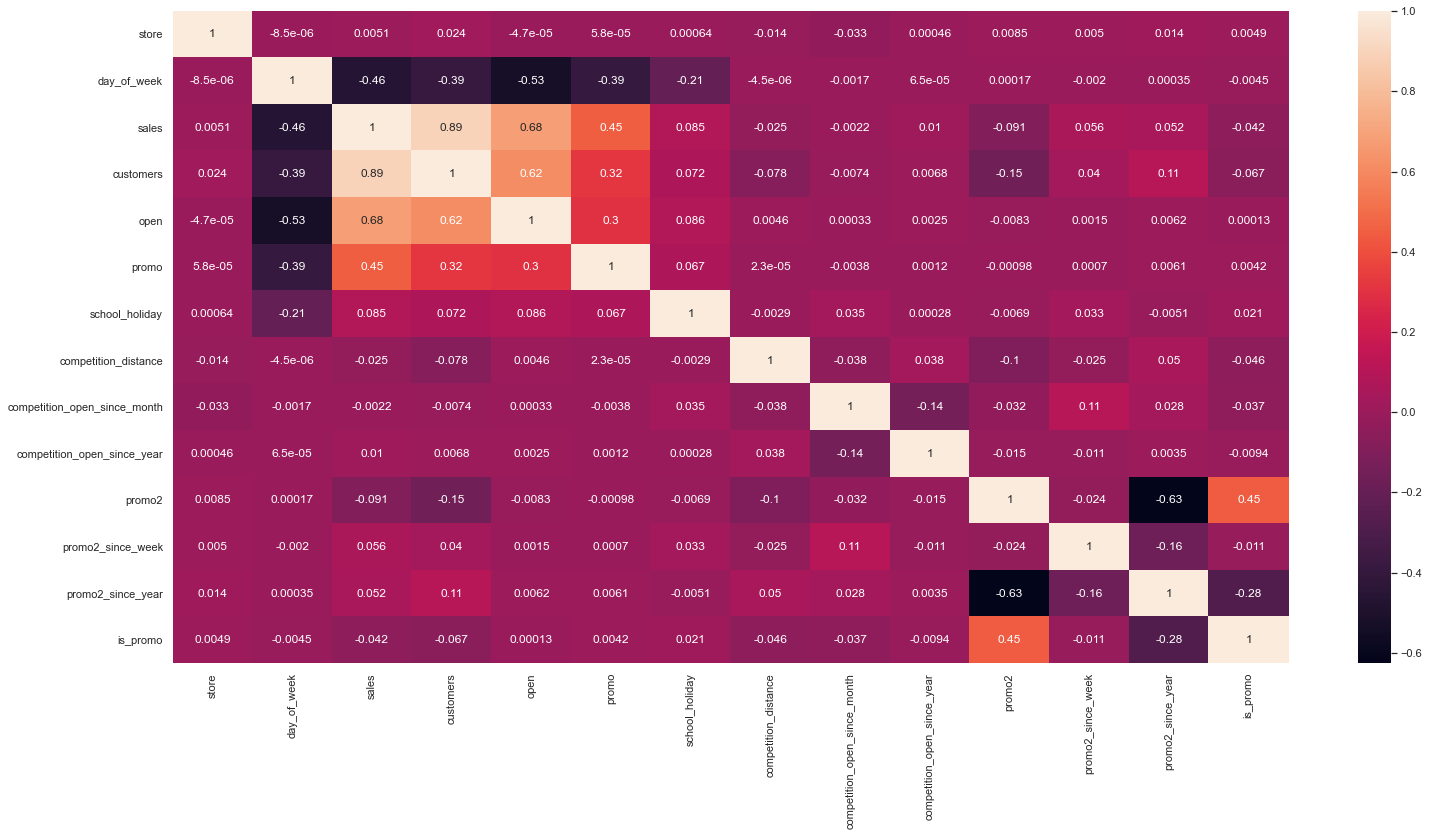

In [86]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 5.3.2. Categorical Attributes

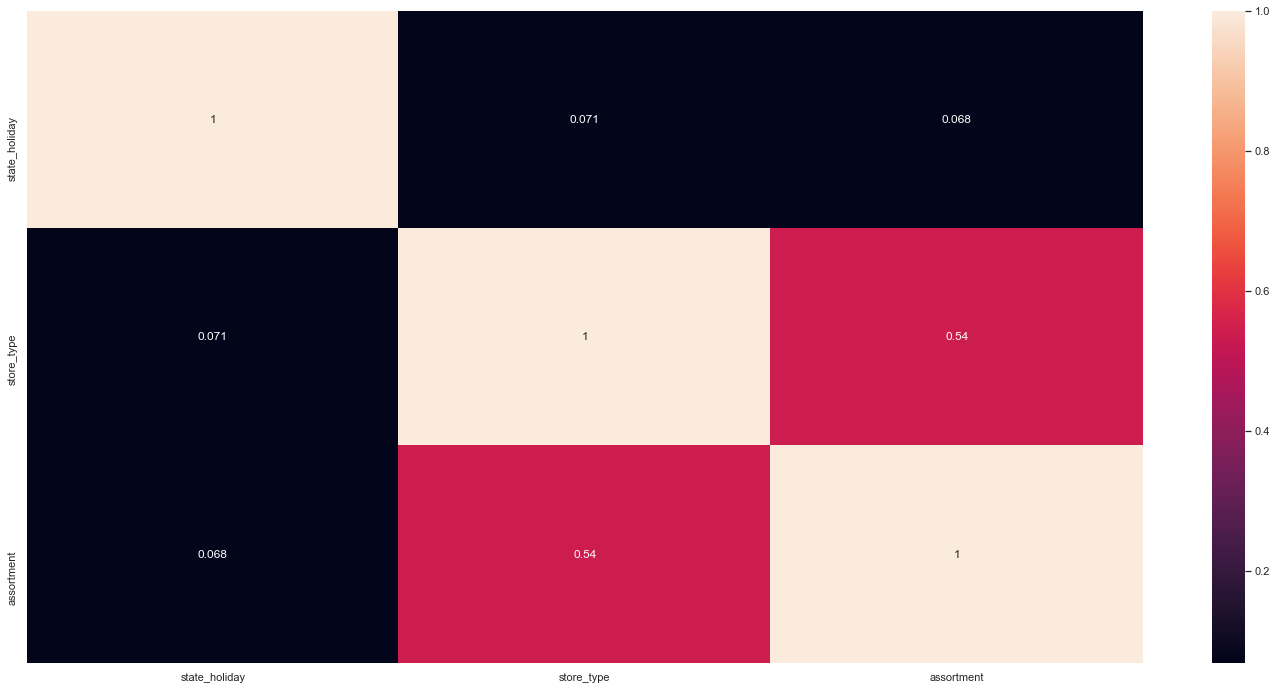

In [88]:
# only categorical data
a = df5.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

## 5.4 Save Dataset - Checkpoint


In [89]:
df5.to_csv('data/05_Rossmann.csv', index = False)

# 6.0 Data Preparation

In [149]:
df6 = df5.copy()

## 6.1. Normalization

In [150]:
#As no attribute follows a normal distribution, normalization will not be done.

## 6.2 Rescaling

In [151]:
rs = RobustScaler()
mms = MinMaxScaler()

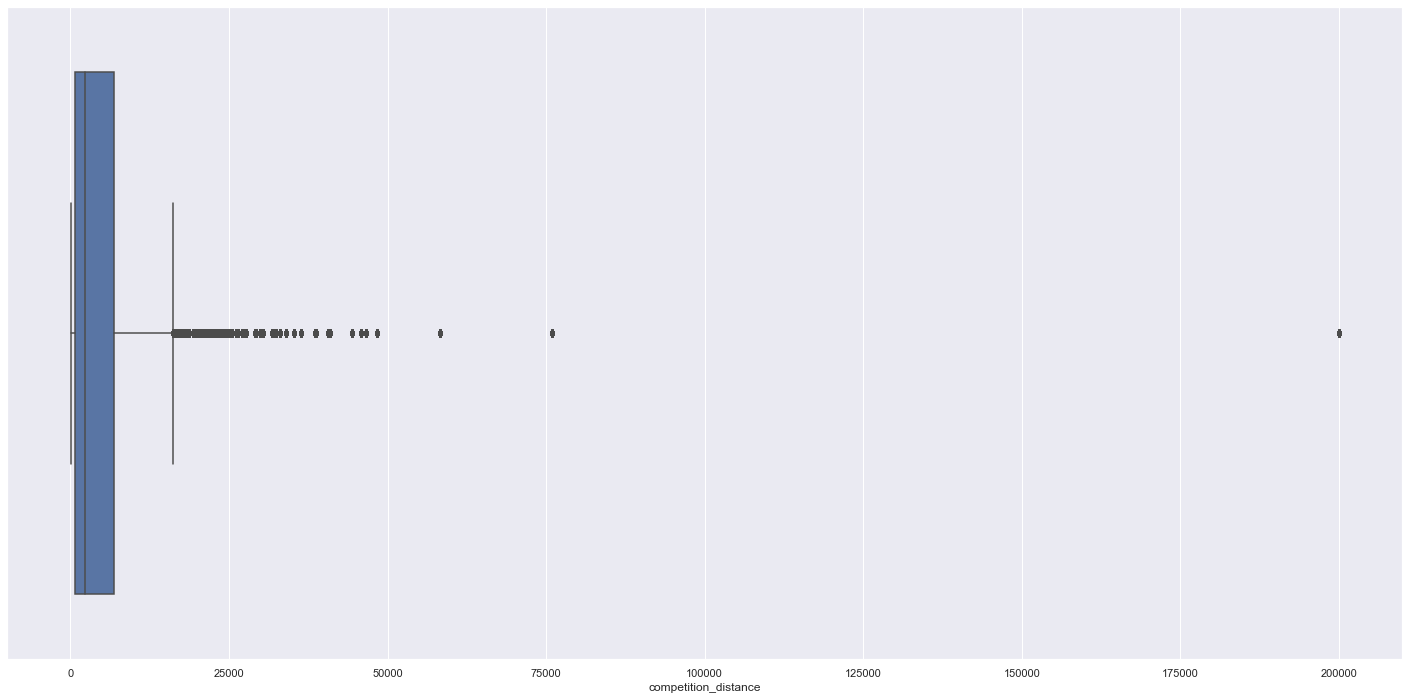

In [152]:
#competition_distance
sns.boxplot(df6['competition_distance']);

In [153]:
#competition_distance - Robust Scaler 
df6['competition_distance'] = rs.fit_transform( df6[['competition_distance']].values )
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))


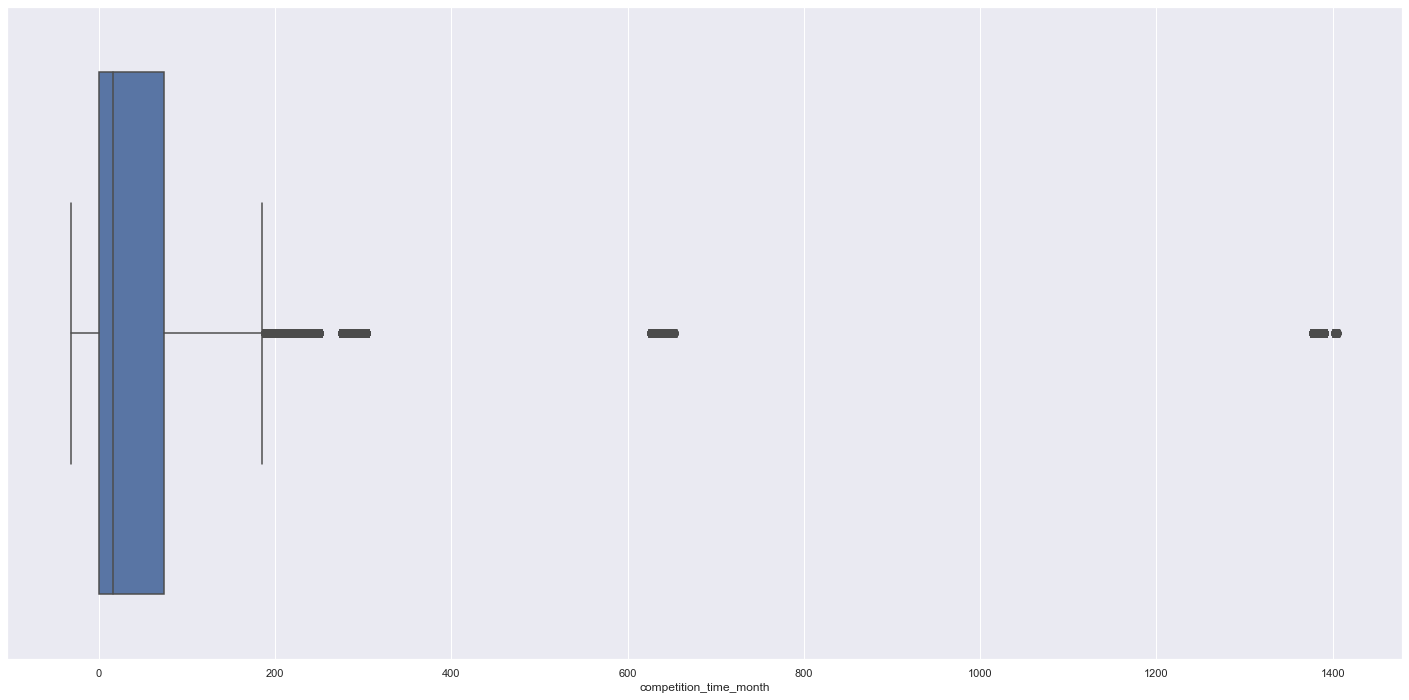

In [154]:
#competition_time_month
sns.boxplot(df6['competition_time_month']);

In [155]:
#competition_time_month - Robust Scaler 
df6['competition_time_month'] = rs.fit_transform( df6[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

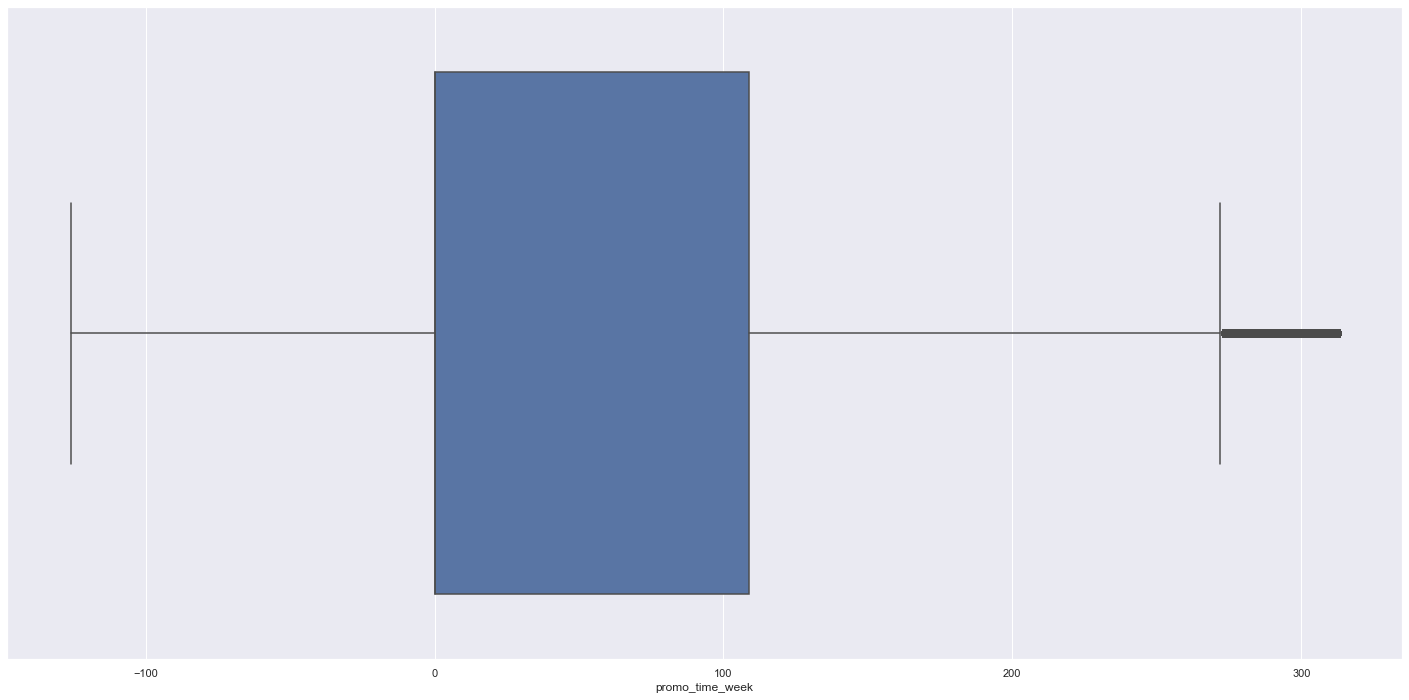

In [156]:
#promo_time_week
sns.boxplot(df6['promo_time_week']);

In [157]:
#promo_time_week - MinMaxScaler
df6['promo_time_week'] = mms.fit_transform( df6[['promo_time_week']].values )
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

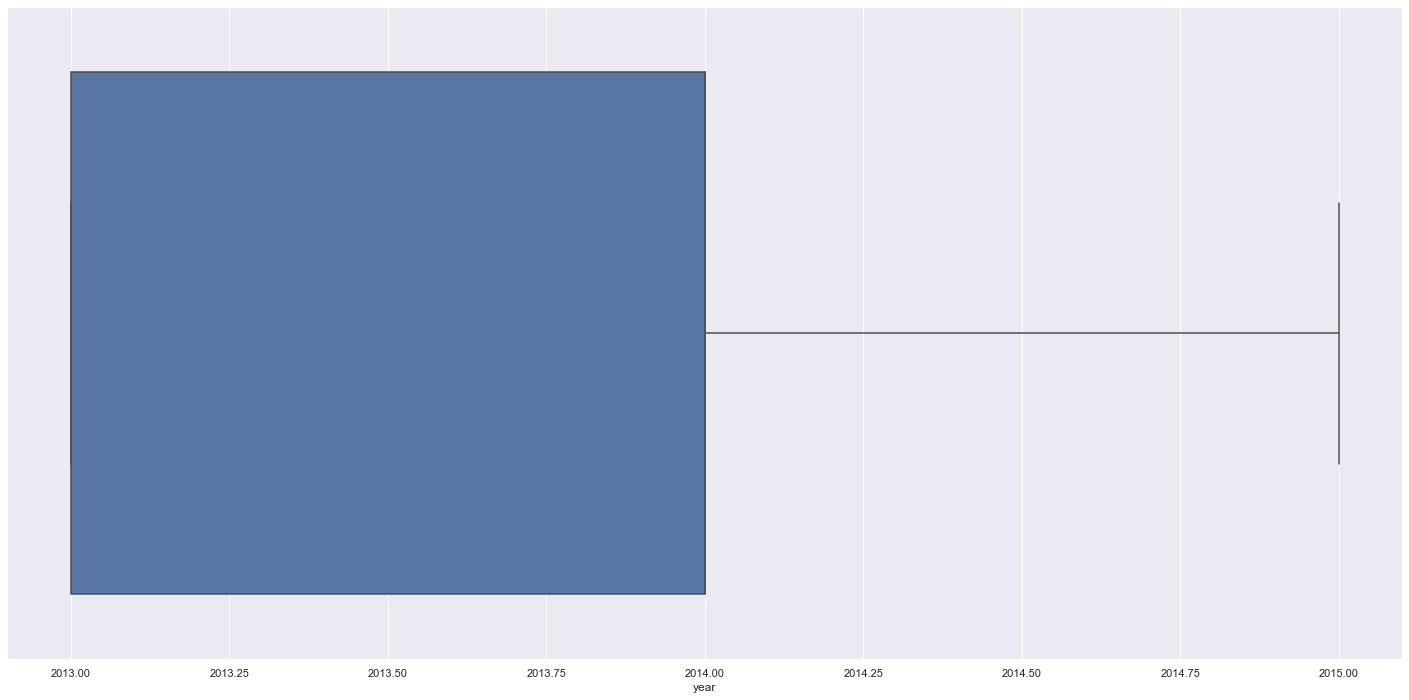

In [158]:
#year
sns.boxplot(df6['year']);

In [159]:
df6['year'] = mms.fit_transform( df6[['year']].values )
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 6.3 Transformation

### 6.3.1 Encoding


In [160]:
df6.select_dtypes(include = ['object']).nunique().sort_values(ascending = False)

year_week        137
store_type         4
state_holiday      4
assortment         3
dtype: int64

In [161]:
#state_holiday - OneHotEncoder
df6 = pd.get_dummies(df6, prefix = ['state_holiday'], columns = ['state_holiday'], drop_first=True)

In [164]:
#store_type - LabelEncoder
le = LabelEncoder()
df6['store_type'] = le.fit_transform( df6['store_type'])

In [169]:
df6['assortment'].drop_duplicates()

0      1
3      3
258    2
Name: assortment, dtype: int64

In [167]:
#assortment - Order encoding
assortment_dict = {'basic': 1, 
                   'extra': 2,
                   'extended' : 3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

In [168]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,1


In [ ]:
#month
#day
#week_of_year
#day_of_week